In [31]:
palette = ['#3B8EA1', '#B84D4A', '#6F5B9A', '#B59F8E', '#D96B9A', '#A3A3A3', '#D88F3B', '#4C9F4A']
from pathlib import Path
single_variants = Path("..") / "data" / "other_data" / "single_variants"
variant_scores = Path("..") / "data" / "processed_scores"
clinical_datasets = Path("..") / "data" / "other_data"/ "clinical_datasets"
figure = Path("..") / "figures"
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import spearmanr, pearsonr
import matplotlib.lines as mlines
from scipy.stats import linregress
from scipy.optimize import curve_fit
from adjustText import adjust_text
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

(1.0, 6.0)

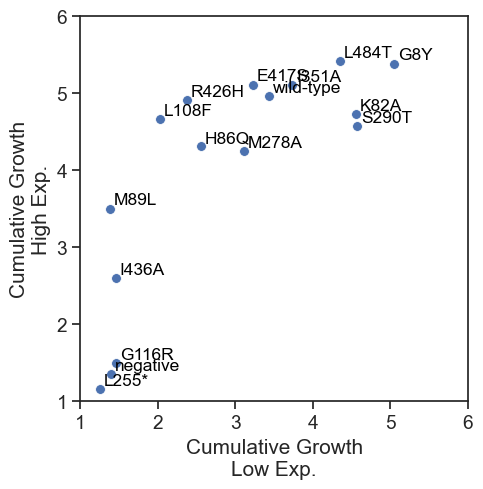

In [5]:
df_model = pd.read_csv(f"{single_variants}\\single_variants.csv")
sns.set(font_scale=1.25, font="arial", rc={'figure.figsize': (5, 5)}, style="ticks")
filtered_df = df_model[df_model["data"] == "growth"]
sns.scatterplot(data=filtered_df, x="Low Exp.", y="High Exp.", s=50)
for i in range(filtered_df.shape[0]):
    plt.text(x=filtered_df["Low Exp."].iloc[i] + 0.05,  # Slight offset for better visibility
             y=filtered_df["High Exp."].iloc[i] + 0.05, 
             s=filtered_df["variant"].iloc[i],
             fontsize=12.5, color='black')
plt.ylabel("Cumulative Growth" + "\n" + "High Exp.")
plt.xlabel("Cumulative Growth" + "\n" + "Low Exp.")
plt.ylim(1, 6)
plt.xlim(1, 6)
#plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight', transparent=True)
#plt.close()

In [6]:
def csv_read(variant_scores = variant_scores):
    high = pd.read_csv(f"{variant_scores}\\highADSL_dox+_fitness_score.csv").rename(columns = {"fitness_score": "fitness_score"})
    high = high[high["sequence_type"]=="single_variant"][["position", "variant","fitness_score", "sequence_type", "barcodes"]]   
    low = pd.read_csv(f"{variant_scores}\\lowADSL_dox+_fitness_score.csv").rename(columns = {"fitness_score": "fitness_score"})
    low = low[low["sequence_type"]=="single_variant"][["position", "variant","fitness_score", "sequence_type", "barcodes"]] 
    df = high.merge(low, on = "variant").rename(columns = {"fitness_score_x":"high", "fitness_score_y":"low", "position_y":"position"})
    df = df[["variant","position", "low","high", "barcodes_x", "barcodes_y"]]
    df["barcode_ave"] = (df["barcodes_x"]+df["barcodes_y"])/2
    wt = pd.DataFrame({'variant': ["wt"], 'position': [""], "low": [1], "high": [1.35], "barcode_ave": [(29820+25246)/2]})
    df = pd.concat([df, wt], ignore_index=True)  
    df_filter = df[(df["low"]>=0) & (df["high"]>=0)]
    return df[["variant", "position", "low", "high", "barcode_ave"]], df_filter

In [7]:
def non_linear_model(VLow, Vmax, N):
    E = (VLow/(Vmax-VLow))
    y = (Vmax*N*E)/(1+(N*E))
    return y
def r_squared(y_actual, y_predicted):
    mean_y_actual = np.mean(y_actual)
    total_sum_of_squares = np.sum((y_actual - mean_y_actual)**2)
    residual_sum_of_squares = np.sum((y_actual - y_predicted)**2)
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r2
def model_fit_nonlinear(df):
    y = third_column = df["high"] # High Exp
    x = fourth_column = df["low"] # Low Exp
    p0 = [1.35, 3.6]
    popt, pcov = curve_fit(non_linear_model, x, y, p0 = p0)
    Vmax, N = popt
    return Vmax, N

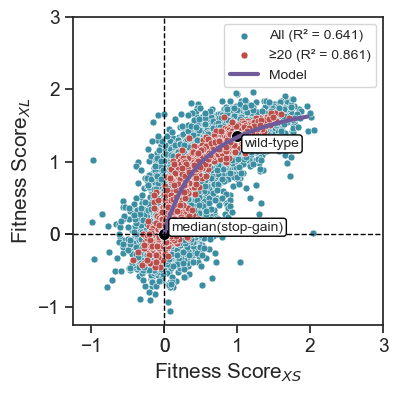

In [8]:
df, df_filter = csv_read()
Vmax, N = model_fit_nonlinear(df_filter)
y_actual = df_filter["high"]
x_actual = df_filter["low"]
y_predicted = non_linear_model(x_actual,  Vmax, N)
r2_value = round(r_squared(y_actual, y_predicted),3)
x_model = np.linspace(min(df_filter["low"]), max(df_filter["high"]), 100)
y_model = non_linear_model(x_model, Vmax, N)
sns.set(font_scale=1.25, font="arial", rc={'figure.figsize': (4, 4)}, style="ticks")
# Define the bins and labels
df['cut-off'] = df['barcode_ave'].apply(lambda x: '>=20' if x > 20 else '<=20')
sns.scatterplot(data=df, x="low", y="high", s = 25, color = palette[0], label = "All (R² = 0.641)")
sns.scatterplot(data=df[df["cut-off"]==">=20"], x="low", y="high", s = 25, color = palette[1], label = "≥20 (R² = 0.861)")
sns.lineplot(x = x_model, y = y_model, color = palette[2], label = f"Model", linewidth = 3)
sns.scatterplot(x=[1], y=[1.35], s=75, color="black")
sns.scatterplot(x=[0], y=[0], s=75, color="black")
plt.axhline(0, color= "black", linestyle="--", linewidth=1)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.ylim(-1.25,3)
plt.yticks([-1,0,0,1,2,3])
plt.ylabel("Fitness Score$_{XL}$")
plt.xlim(-1.25,3)
plt.xticks([-1,0,0,1,2,3])
plt.xlabel("Fitness Score$_{XS}$")
plt.text(1.1,1.2, "wild-type", fontsize = 10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
plt.text(0.1,0.05, "median(stop-gain)", fontsize = 10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
plt.legend(loc = "best", fontsize = 10)
#plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight')
#plt.close()

In [9]:
def curve_fit_plot(cut_off):
    df, df_filter = csv_read()
    df_filter = df_filter[(df_filter["barcodes_x"] >= cut_off) & (df_filter["barcodes_y"] >= cut_off)]
    Vmax, N = model_fit_nonlinear(df_filter)
    y_actual = df_filter["high"]
    x_actual = df_filter["low"]
    y_predicted = non_linear_model(x_actual,  Vmax, N)
    r2_value = round(r_squared(y_actual, y_predicted),3)
    x_model = np.linspace(min(df_filter["low"]), max(df_filter["high"]), 100)
    y_model = non_linear_model(x_model, Vmax, N)
    sns.set(font_scale = 1.25, font = "arial", rc={'figure.figsize':(5,5)}, style = "ticks")
    sns.scatterplot(data = df, x = "low", y = "high", color = palette[0], label = "Variant Effect Scores")
    sns.lineplot(x = x_model, y = y_model, color = palette[2], label = f"Non-Linear Model", linewidth = 5)
    plt.axhline(0, color= "black", linestyle="--", linewidth=1)
    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.ylim(-1.25,2.5)
    plt.ylabel("Fitness Scores" + "\n" + "High Exp.")
    plt.xlim(-1.25,2.5)
    plt.xlabel("Fitness Scores" + "\n" + "Low Exp.")
    plt.legend(fontsize=12.5)
    print(f"r_square: {r2_value}")
    print(f"Vmax: {Vmax}")
    print(f"N: {N}")
    plt.text(1.5, 2.25, f"R2: {r2_value}", fontsize=12, color='black', weight="bold")
    #plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight')
    #plt.close()
    return 

r_square: 0.641
Vmax: 1.523232764249603
N: 3.711507186788635


3.96

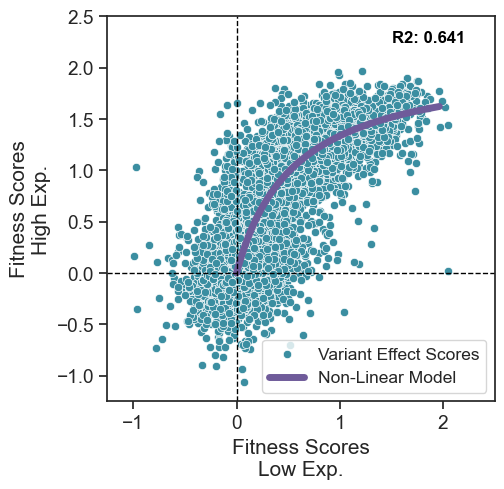

In [10]:
curve_fit_plot(0)
round(3.9588357500321947,2)

(0.0, 5.0)

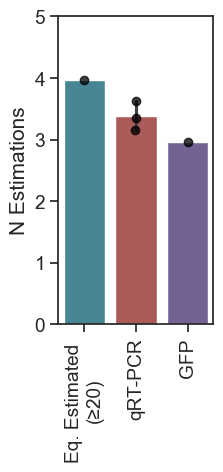

In [11]:
df_estimates = pd.DataFrame({"Measurements":["Eq. Estimated \n(≥20)", "qRT-PCR", "qRT-PCR", "qRT-PCR", "GFP"], 
                             "values":[3.96, 3.62, 3.35, 3.16, 2.96]})
sns.set(font_scale = 1.25, font = "arial", rc={'figure.figsize':(2,4)}, style = "ticks")
sns.barplot(data = df_estimates, x = "Measurements", y = "values", hue = "Measurements", palette = palette[0:3])
sns.stripplot(data=df_estimates, x="Measurements", y="values", color="black", size=6, linewidth=1, edgecolor="black", alpha=0.75)


plt.ylabel("N Estimations")
plt.xlabel("")
plt.xticks([0,1,2], rotation = 90)
plt.ylim(0,5)
#plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight')
#plt.close()

In [12]:
#y = -0.0373x**2 - 0.0028x + 0.3674, R² = 0.1362 low exp. error correction equation
#y = -0.0879x**2 - 0.0186x + 0.4655, R² = 0.6654 high exp. error correction equation

#formula:
#fitness_score vs sem*sqrt(barcode), polynomial second order


In [13]:
low = pd.read_csv(f"{variant_scores}\\lowADSL_dox+_fitness_score.csv")[["variant", "fitness_score", 
                                                                        "sem", "barcodes", "sequence_type", "variant_type"]]
low['corr_se'] = (-0.0373 * low['fitness_score']**2 - 0.0028 * low['fitness_score'] + 0.3674) / np.sqrt(low['barcodes'])
#corrected se (parameters are from fitted curve, sd vs score)
vmax = 1.5692503883206486
low["Ei_possible"] = low['fitness_score']+low['corr_se']<vmax
low["Ei"] = (low["fitness_score"])/(1*(vmax-low["fitness_score"])) #low exp.
low["Ei_se"] = low['corr_se']*vmax/((vmax-low['fitness_score'])**2)
low = low[low["Ei_possible"]==True]

In [15]:
high = pd.read_csv(f"{variant_scores}\\highADSL_dox+_fitness_score.csv")[["variant", "fitness_score", "sem",
                                                                        "barcodes", "sequence_type", "variant_type"]]
high['corr_se'] = (-0.0879 * high['fitness_score']**2 - 0.0186 * high['fitness_score'] + 0.4655) / np.sqrt(high['barcodes'])
#corrected se (parameters are from fitted curve, sd vs score)
vmax = 1.5692503883206486
N = 3.9588357500321947
high["Ei_possible"] = high['fitness_score']+high['corr_se']<vmax
high["Ei"] = (high["fitness_score"])/(N*(vmax-high["fitness_score"])) #high exp.
high["Ei_se"] = high['corr_se']*vmax/(N*(vmax-high['fitness_score'])**2)
high = high[high["Ei_possible"]==True]

In [16]:
df_low = low[low["variant_type"]!="synonymous"][["variant", "fitness_score", "Ei", "Ei_se", "sequence_type", "variant_type"]].rename(columns = {
    "fitness_score":"fitness_score_low",
    "Ei":"Ei_low", 
    "Ei_se":"Ei_se_low"})
df_low["weight_low"] = df_low.apply(lambda row: 1/(row['Ei_se_low']**2) if row['Ei_se_low'] != np.nan else np.nan, axis=1)
df_high = high[high["variant_type"]!="synonymous"][["variant", "fitness_score", "Ei", "Ei_se", "sequence_type", "variant_type"]].rename(columns = {
    "fitness_score":"fitness_score_high",
    "Ei":"Ei_high", 
    "Ei_se":"Ei_se_high"})
df_high["weight_high"] = df_high.apply(lambda row: 1/(row['Ei_se_high']**2) if row['Ei_se_high'] != np.nan else np.nan, axis=1)

In [17]:
df = df_low.merge(df_high, on = "variant", how='outer')

In [18]:
df['sequence_type'] = df['sequence_type_x'].fillna(df['sequence_type_y'])
df = df.drop(columns=['sequence_type_x', 'sequence_type_y'])
df['variant_type'] = df['variant_type_x'].fillna(df['variant_type_y'])
df = df.drop(columns=['variant_type_x', 'variant_type_y'])

In [19]:
def calculate_weighted_mean_and_error(row):
    # Extract scores and weights
    score_1 = row['Ei_low']
    weight_1 = row['weight_low']
    Ei_se_1 = row['Ei_se_low']

    score_2 = row['Ei_high']
    weight_2 = row['weight_high']
    Ei_se_2 = row['Ei_se_high'] 

    # Initialize variables
    weighted_mean = np.nan
    weighted_error = np.nan
    consensus_error = np.nan

    # Check if both scores and weights are available
    if pd.notna(score_1) and pd.notna(score_2):
        total_weight = weight_1 + weight_2
        weighted_mean = (score_1 * weight_1 + score_2 * weight_2) / total_weight

        # Calculate weighted variance......... se_consensus = 1/sqrt(we_1+we_2)
        weighted_variance = ((weight_1 * (score_1 - weighted_mean)**2 + 
                              weight_2 * (score_2 - weighted_mean)**2) / 
                             total_weight)
        # Calculate weighted standard deviation (error)
        weighted_error = np.sqrt(weighted_variance)
        # Calculate weighted variance......... uncertanity = 1/sqrt(we_1+we_2)
        w1 = 1/(Ei_se_1**2)
        w2 = 1/(Ei_se_2**2)
        # Calculate consensus standard deviation (error)
        consensus_error = np.sqrt(1/(w1+w2))

    

    elif pd.notna(score_1):
        weighted_mean = score_1  # Use only score_1 if score_2 is missing
        weighted_error = np.nan  # Unreliable estimate
        consensus_error = Ei_se_1

    elif pd.notna(score_2):
        weighted_mean = score_2  # Use only score_2 if score_1 is missing
        weighted_error = np.nan  # Unreliable estimate
        consensus_error = Ei_se_2

    return weighted_mean, weighted_error, consensus_error

In [22]:
df[['Est_Ei', 'Est_Ei_error', "Ei_serror"]] = df.apply(calculate_weighted_mean_and_error, axis=1, result_type='expand')
df['Low_Ei'] = df['Est_Ei']*1
N = 3.9588357500321947
df['High_Ei'] = df['Est_Ei']*N
df[["variant", "Est_Ei", "Est_Ei_error", "Ei_serror", "Low_Ei", "High_Ei", "sequence_type", "variant_type"]].to_csv(f"{variant_scores}\\ADSL_Est_Ei.csv", index = False)
x = df[["variant", "fitness_score_low", "Low_Ei"]].rename(columns = {"fitness_score_low":"fitness", "Low_Ei": "Ei"})
y = df[["variant", "fitness_score_high", "High_Ei"]].rename(columns = {"fitness_score_high":"fitness", "High_Ei": "Ei"})
plot = pd.concat([x,y], axis = 0).reset_index(drop = True)

'\nsns.set(font_scale=1.25, font="arial", rc={\'figure.figsize\': (1, 5)}, style="ticks")\nsns.scatterplot(data = plot, x = "Ei", y = "fitness", color = palette[0])\nplt.ylim(-1,2)\nplt.xlim(10,30)\nplt.xlabel("")\nplt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches=\'tight\', transparent=True)\nplt.close()\n'

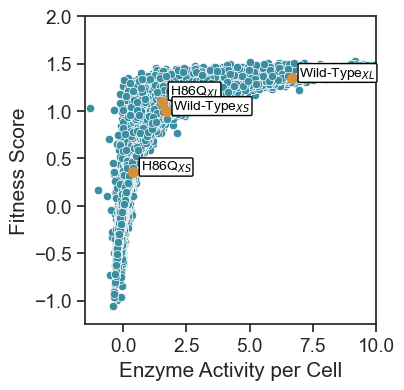

In [23]:
sns.set(font_scale=1.25, font="arial", rc={'figure.figsize': (3.75, 4)}, style="ticks")
sns.scatterplot(data = plot, x = "Ei", y = "fitness", color = palette[0])
plt.ylim(-1.25,2)
for i, row in x.iterrows():
    if row['variant'] == "H86Q":  # Condition to select the specific point to label
        plt.scatter(row['Ei'], row['fitness'], color=palette[6], s=50, marker='o')
        plt.text(row['Ei'] + 0.3, row['fitness'] + 0.02, 'H86Q$_{XS}$',
                 fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
for i, row in y.iterrows():
    if row['variant'] == "H86Q":  # Condition to select the specific point to label
        plt.scatter(row['Ei'], row['fitness'], color=palette[6], s=50, marker='o')
        plt.text(row['Ei'] + 0.3, row['fitness'] + 0.075, 'H86Q$_{XL}$',
                 fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
for i, row in x.iterrows():
    if row['variant'] == "wild-type":  # Condition to select the specific point to label
        plt.scatter(row['Ei'], row['fitness'], color=palette[6], s=50, marker='o')
        plt.text(row['Ei'] + 0.3, row['fitness'] + 0.02, 'Wild-Type$_{XS}$',
                 fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
for i, row in y.iterrows():
    if row['variant'] == "wild-type":  # Condition to select the specific point to label
        plt.scatter(row['Ei'], row['fitness'], color=palette[6], s=50, marker='o')
        plt.text(row['Ei'] + 0.3, row['fitness'] + 0.02, 'Wild-Type$_{XL}$',
                 fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
plt.ylabel("Fitness Score")
plt.xlabel("Enzyme Activity per Cell")
plt.xlim(-1.5,10)
#plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight', transparent=True)
#plt.close()
"""
sns.set(font_scale=1.25, font="arial", rc={'figure.figsize': (1, 5)}, style="ticks")
sns.scatterplot(data = plot, x = "Ei", y = "fitness", color = palette[0])
plt.ylim(-1,2)
plt.xlim(10,30)
plt.xlabel("")
plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight', transparent=True)
plt.close()
"""

In [28]:
df_recom_enz = pd.read_csv(f"{clinical_datasets}\\ADSL_recom_enzyme_activities.csv")
#------
couple = ["samp","Ei_%"]
#------
data = df_recom_enz[[couple[0], couple[1]]].dropna()
corr, p_value = spearmanr(data[couple[0]], data[couple[1]])

print("Spearman correlation:", round(corr,4))
print("p-value:", round(p_value,4))

Spearman correlation: 0.481
p-value: 0.0062


In [29]:
corr = pd.DataFrame({
    "substrate": ["samp", "samp", "samp", "saicar", "saicar", "saicar"],
    "dataset": ["Ei_%", "low_%", "high_%", "Ei_%", "low_%", "high_%"],
    "spearman": [0.4810, 0.4954, 0.5665, 0.59, 0.5677, 0.6055],
    "p_value": [0.0062, 0.0101, 0.0009, 0.0005, 0.0025, 0.0003]
})

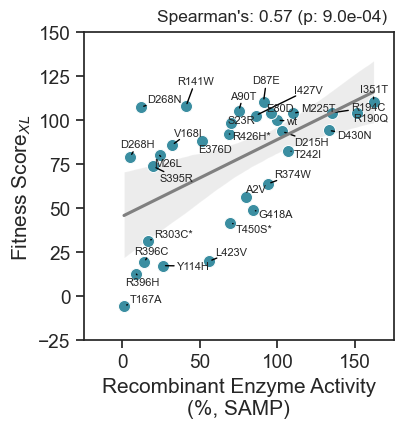

In [30]:
# Extract Spearman & p-value
sample = ["samp", "high_%"]
correlations = corr.loc[(corr["substrate"] == sample[0]) & (corr["dataset"] == sample[1]),["spearman", "p_value"]].values.flatten().tolist()
sns.set(font_scale=1.25, font="arial", rc={'figure.figsize': (4, 4)}, style="ticks")
plot = df_recom_enz[["variant",sample[0],sample[1]]].dropna()
sns.regplot(data=plot, x=sample[0], y=sample[1], scatter=False, color="grey")
sns.scatterplot(data=plot, x=sample[0], y=sample[1], s=75, color=palette[0])
# Annotate variants
annotated_variants = {}
texts = []
for index, row in plot[::-1].iterrows():
    variant = row["variant"]
    if variant not in annotated_variants:
        texts.append(plt.text(row[sample[0]], row[sample[1]], variant, fontsize=8))
        annotated_variants[variant] = True
# Adjust text
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), expand=(1.5, 1.5))
# Regression legend (if needed)
regression_line = mlines.Line2D([], [], color="grey", linewidth=1, linestyle=":")

# Spearman annotation
plt.annotate(f"Spearman's: {correlations[0]:.2f} "
             f"(p: {correlations[1]:.1e})",
             xy=(0.98, 1.075), xycoords='axes fraction',
             ha='right', va='top', fontsize=12.5)

#plt.ylim(-25,250) #Ei
#plt.ylabel("Estimated Enzyme Activity (%)")

plt.ylim(-25,150) #fitness
if sample[1]=="low_%":
    plt.ylabel("Fitness Score$_{XS}$")
if sample[1]=="high_%":
    plt.ylabel("Fitness Score$_{XL}$")

plt.xlim(-25,175)
if sample[0]=="samp":
    plt.xlabel("Recombinant Enzyme Activity" + "\n" "(%, SAMP)")
if sample[0]=="saicar":
    plt.xlabel("Recombinant Enzyme Activity" + "\n" "(%, SAICAR)")
#plt.savefig(f"{figure}figure.svg", format = "svg", bbox_inches='tight', transparent=True)
#plt.close()